# 03. Public Repo Summary Charts
This contains a few summary stats and basic charts to get a better understanding of repo.


## Load and Format Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import pull_fred
import pull_public_repo_data

In [2]:
from pathlib import Path
from settings import config

OUTPUT_DIR = Path(config("OUTPUT_DIR"))
DATA_DIR = Path(config("DATA_DIR"))

In [3]:
pull_public_repo_data.series_descriptions

{'GDP': 'GDP',
 'CPIAUCNS': 'Consumer Price Index for All Urban Consumers: All Items in U.S. City Average',
 'GDPC1': 'Real Gross Domestic Product',
 'DPCREDIT': 'Discount Window Primary Credit Rate',
 'EFFR': 'Effective Federal Funds Rate',
 'OBFR': 'Overnight Bank Funding Rate',
 'SOFR': 'SOFR',
 'IORR': 'Interest on Required Reserves',
 'IOER': 'Interest on Excess Reserves',
 'IORB': 'Interest on Reserve Balances',
 'DFEDTARU': 'Federal Funds Target Range - Upper Limit',
 'DFEDTARL': 'Federal Funds Target Range - Lower Limit',
 'WALCL': 'Federal Reserve Total Assets',
 'TOTRESNS': 'Reserves of Depository Institutions: Total',
 'TREAST': 'Treasuries Held by Federal Reserve',
 'CURRCIR': 'Currency in Circulation',
 'GFDEBTN': 'Federal Debt: Total Public Debt',
 'WTREGEN': 'Treasury General Account',
 'RRPONTSYAWARD': 'Fed ON/RRP Award Rate',
 'RRPONTSYD': 'Treasuries Fed Sold In Temp Open Mark',
 'RPONTSYD': 'Treasuries Fed Purchased In Temp Open Mark',
 'WSDONTL': 'SOMA Sec Overnight

In [4]:
df = pull_public_repo_data.load_all(data_dir = DATA_DIR)
df = df.loc["2012-01-01":,:]

df['target_midpoint'] = (df['DFEDTARU'] + df['DFEDTARL'])/2
df['SOFR-IORB'] = df['SOFR'] - df['Gen_IORB']

df['Fed Balance Sheet / GDP'] = df['WALCL'] / df['GDP']
df['Tri-Party - Fed ON/RRP Rate'] = (df['REPO-TRI_AR_OO-P'] - df['RRPONTSYAWARD']) * 100
df['Tri-Party Rate Less Fed Funds Upper Limit'] = (df['REPO-TRI_AR_OO-P'] - df['DFEDTARU']) * 100
df['Tri-Party Rate Less Fed Funds Midpoint'] = (df['REPO-TRI_AR_OO-P'] - (df['DFEDTARU'] + df['DFEDTARL'])/2) * 100

df['net_fed_repo'] = (df['RPONTSYD'] - df['RRPONTSYD']) / 1000 # Fed Repo minus reverse repo volume
df['Total Reserves / Currency'] = df['TOTRESNS'] / df['CURRCIR'] # total reserves among depository institutions vs currency in circulation
df['Total Reserves / GDP'] = df['TOTRESNS'] / df['GDP']

df['SOFR (extended with Tri-Party)'] = df['SOFR'].fillna(df['REPO-TRI_AR_OO-P'])

new_labels = {
    'REPO-TRI_AR_OO-P':'Tri-Party Overnight Average Rate',
    'RRPONTSYAWARD': 'ON-RRP facility rate',
    'Gen_IORB': 'Interest on Reserves',
}


### Rates Relative to Fed Funds Target Midpoint
Normalize rates to be centered at the fed funds target window midpoint.

In [5]:
df_norm = pd.DataFrame().reindex_like(df[['target_midpoint']])
df_norm[['target_midpoint']] = 0

for s in ['DFEDTARU', 'DFEDTARL', 'REPO-TRI_AR_OO-P', 
          'EFFR', 'target_midpoint', 
          'Gen_IORB', 'RRPONTSYAWARD', 
          'SOFR', "SOFR (extended with Tri-Party)",
          "FNYR-BGCR-A", "FNYR-TGCR-A"]:
    df_norm[s] = df[s] - df['target_midpoint']


## Replicate "Anatomy of a Repo Spike" Charts

Replicate Figure 1 from "Anatomy of the Repo Rate Spikes"

<Axes: xlabel='DATE'>

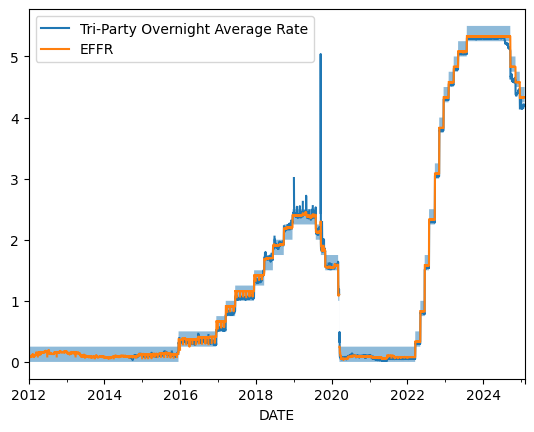

In [6]:
fig, ax = plt.subplots()
ax.fill_between(df.index, df['DFEDTARU'], df['DFEDTARL'], alpha=0.5)
df[['REPO-TRI_AR_OO-P', 'EFFR']].rename(columns=new_labels).plot(ax=ax)

<Axes: xlabel='DATE'>

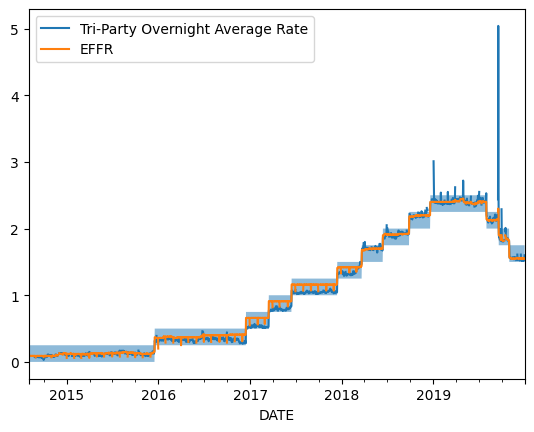

In [7]:
fig, ax = plt.subplots()
date_start = '2014-Aug'
date_end = '2019-Dec'
_df = df.loc[date_start:date_end, :]
ax.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.5)
_df[['REPO-TRI_AR_OO-P', 'EFFR']].rename(columns=new_labels).plot(ax=ax)
# plt.ylim(-0.2, 1.0)

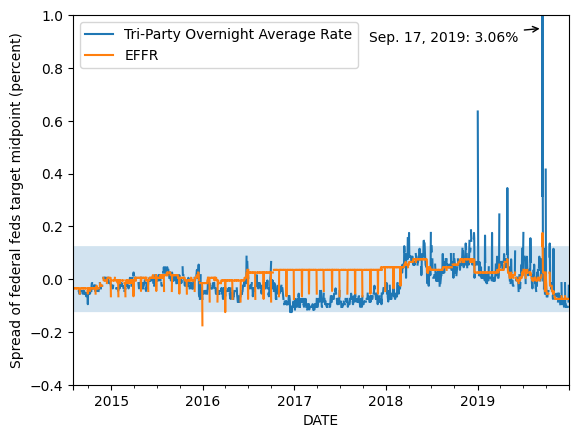

In [8]:
fig, ax = plt.subplots()
date_start = '2014-Aug'
date_end = '2019-Dec'
_df = df_norm.loc[date_start:date_end, :]
ax.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.2)
_df[['REPO-TRI_AR_OO-P', 'EFFR']].rename(columns=new_labels).plot(ax=ax)
plt.ylim(-0.4, 1.0)
plt.ylabel("Spread of federal feds target midpoint (percent)")
arrowprops = dict( 
    arrowstyle = "->"
)
ax.annotate('Sep. 17, 2019: 3.06%', 
            xy=('2019-Sep-17', 0.95), 
            xytext=('2017-Oct-27', 0.9),
            arrowprops = arrowprops);

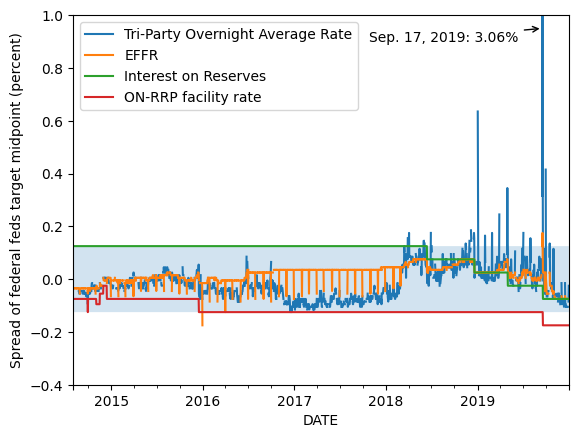

In [9]:
fig, ax = plt.subplots()
date_start = '2014-Aug'
date_end = '2019-Dec'
_df = df_norm.loc[date_start:date_end, :].copy()

ax.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.2)
_df[['REPO-TRI_AR_OO-P', 'EFFR', 'Gen_IORB', 'RRPONTSYAWARD']].rename(columns=new_labels).plot(ax=ax)
plt.ylim(-0.4, 1.0)
plt.ylabel("Spread of federal feds target midpoint (percent)")
arrowprops = dict( 
    arrowstyle = "->"
)
ax.annotate('Sep. 17, 2019: 3.06%', 
            xy=('2019-Sep-17', 0.95), 
            xytext=('2017-Oct-27', 0.9),
            arrowprops = arrowprops);

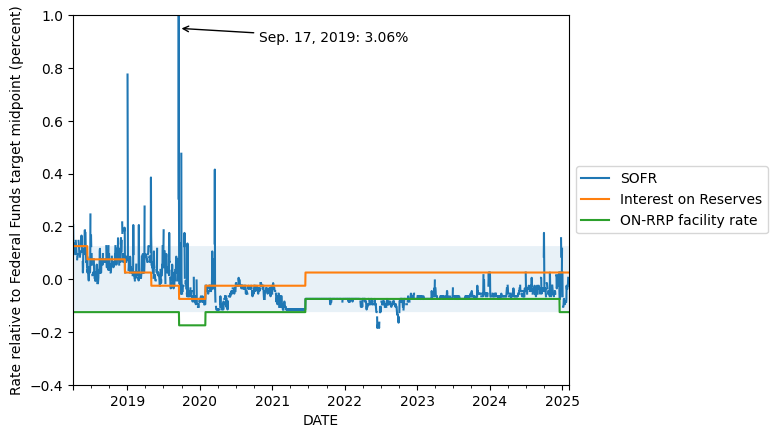

In [10]:
fig, ax = plt.subplots()
date_start = '2018-Apr'
date_end = None
_df = df_norm.loc[date_start:date_end, :].copy()

ax.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.1)
_df = _df[[
    'SOFR', 
    # 'EFFR', 
    'Gen_IORB', 
    'RRPONTSYAWARD'
    ]].rename(columns=new_labels)
_df.plot(ax=ax)
plt.ylim(-0.4, 1.0)
plt.ylabel("Rate relative to Federal Funds target midpoint (percent)")
arrowprops = dict( 
    arrowstyle = "->"
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.annotate('Sep. 17, 2019: 3.06%', 
            xy=('2019-Sep-17', 0.95), 
            xytext=('2020-Oct-27', 0.9),
            arrowprops = arrowprops);



# plt.tight_layout()
plt.savefig(OUTPUT_DIR / "rates_relative_to_midpoint.png")

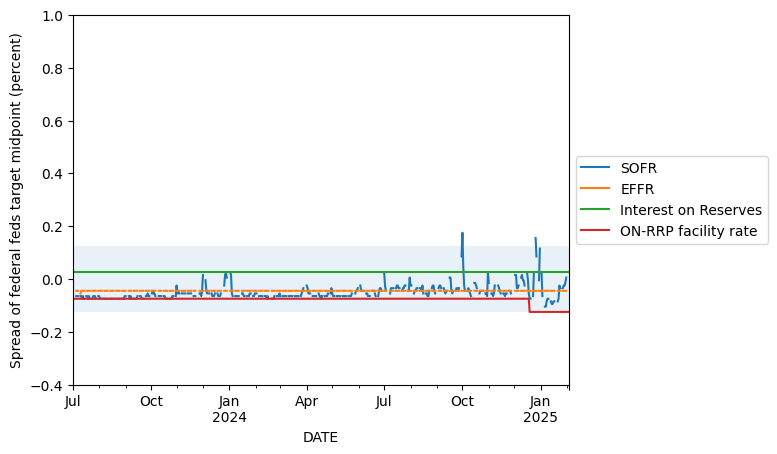

In [11]:
fig, ax = plt.subplots()
date_start = '2023-Jul'
date_end = None
_df = df_norm.loc[date_start:date_end, :].copy()

ax.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.1)
_df[['SOFR', 'EFFR', 'Gen_IORB', 'RRPONTSYAWARD']].rename(columns=new_labels).plot(ax=ax)
plt.ylim(-0.4, 1.0)
plt.ylabel("Spread of federal feds target midpoint (percent)")
arrowprops = dict( 
    arrowstyle = "->"
)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.annotate('Sep. 17, 2019: 3.06%', 
#             xy=('2019-Sep-17', 0.95), 
#             xytext=('2015-Oct-27', 0.9),
#             arrowprops = arrowprops);


## Understanding this plot

Now, let's spend some time trying to understand this plot. 

### Reserve Levels vs Spikes
First of all, depository intitutions have a choice between keeping their reserves at the Fed and earning interest on reserve balances or lending the money into repo. When the repo rates were spiking in 2018 and 2019, I would imagine that total reserve levels would be low.

In [12]:
df['net_fed_repo'] = (df['RPONTSYD'] - df['RRPONTSYD']) / 1000
df['triparty_less_fed_onrrp_rate'] = (df['REPO-TRI_AR_OO-P'] - df['RRPONTSYAWARD']) * 100
df['total reserves / currency'] = df['TOTRESNS'] / df['CURRCIR']

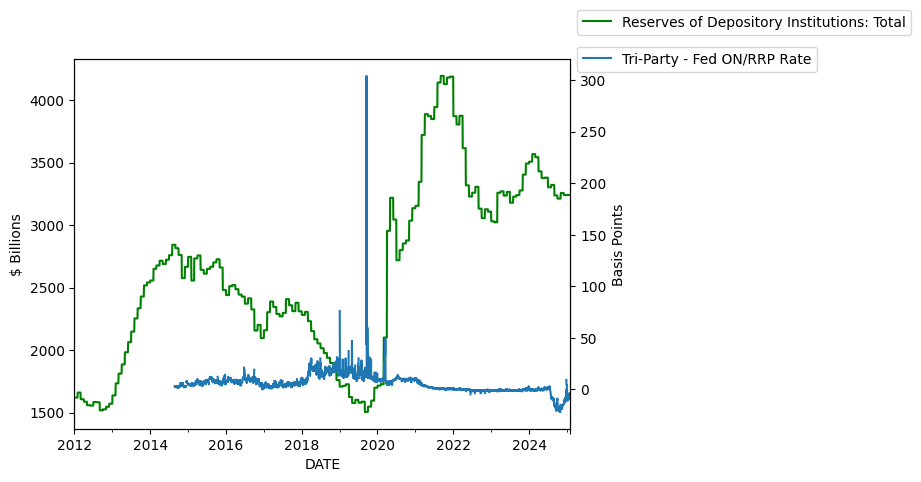

In [13]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df[['TOTRESNS']].rename(
    columns=pull_public_repo_data.series_descriptions
).plot(ax=ax1,color='g')
ax1.set_ylabel('$ Billions')
ax2.set_ylabel('Basis Points')
ax1.legend(loc='center left', bbox_to_anchor=(1, 1.1))
df[['Tri-Party - Fed ON/RRP Rate']].plot(ax=ax2)
ax2.legend(loc='center left', bbox_to_anchor=(1, 1));


Now, let's normalize by currency in circulation, so as to account for the normal growth in the economy or the financial system. This is done because total reserves is not stationary.

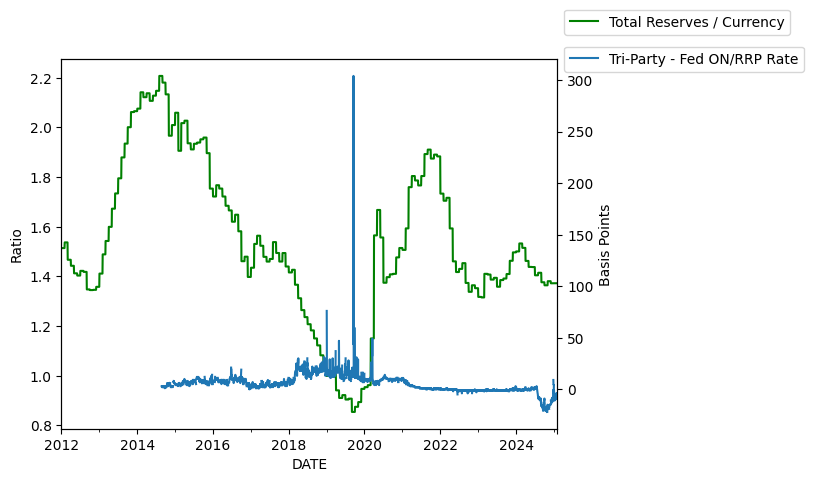

In [14]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
_df = df[['Tri-Party - Fed ON/RRP Rate', 'Total Reserves / Currency']]
_df[['Total Reserves / Currency']].plot(ax=ax1,color='g')
_df[['Tri-Party - Fed ON/RRP Rate']].plot(ax=ax2)
ax1.set_ylabel('Ratio')
ax2.set_ylabel('Basis Points')
ax1.legend(loc='center left', bbox_to_anchor=(1, 1.1))
ax2.legend(loc='center left', bbox_to_anchor=(1, 1));

# # Shrink current axis's height by 10% on the bottom
# box = ax.get_position()
# ax1.set_position([box.x0, box.y0 + box.height * 0.1,
#                  box.width, box.height * 0.9])

# # Put a legend below current axis
# ax1.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# ax2.legend(loc='lower center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)

# plt.tight_layout()
# Total Reserves held by depository institutions, divided by currency in circulation
plt.savefig(OUTPUT_DIR / "repo_rate_spikes_and_relative_reserves_levels.png")

### Fed Balance Sheet Size vs Spikes

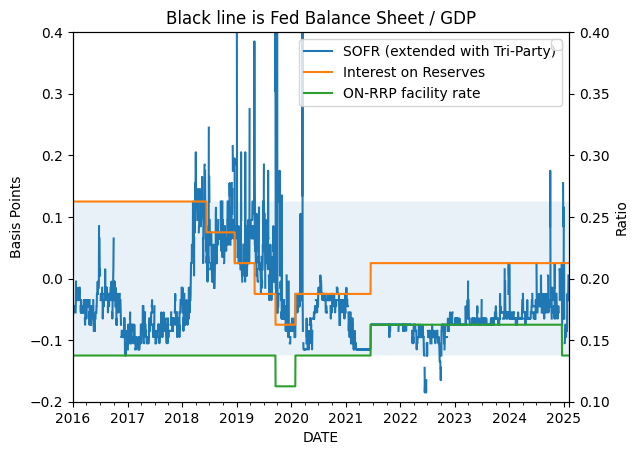

In [15]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

date_start = '2016-Jan'
date_end = None

_df = df_norm.loc[date_start:date_end, :].copy()
_df = _df[[
    'SOFR (extended with Tri-Party)', 
    # "FNYR-BGCR-A",
    # 'EFFR', 
    # "FNYR-BGCR-A", 
    # "FNYR-TGCR-A",
    'Gen_IORB', 
    'RRPONTSYAWARD',
    "DFEDTARU", # Fed Funds Upper Limit
    "DFEDTARL", # Fed Funds Lower Limit
    ]].rename(columns=new_labels)
cols = [
    # 'Tri-Party - Fed ON/RRP Rate', 
    'Fed Balance Sheet / GDP',
]
for col in cols:
    _df[col] = df[col]
_df.to_excel(DATA_DIR / "AR2024_SEC_4_2_Fed_Balance_Sheet_Repo.xlsx")

ax1.fill_between(_df.index, _df['DFEDTARU'], _df['DFEDTARL'], alpha=0.1)

_df = df_norm.loc[date_start:date_end, :].copy()
_df = _df[[
    'SOFR (extended with Tri-Party)', 
    # "FNYR-BGCR-A",
    # 'EFFR', 
    # "FNYR-BGCR-A", 
    # "FNYR-TGCR-A",
    'Gen_IORB', 
    'RRPONTSYAWARD'
    ]].rename(columns=new_labels)
_df.plot(ax=ax1)
plt.ylim(-0.4, 1.0)
plt.ylabel("Rate relative to Federal Funds target midpoint (percent)")
arrowprops = dict( 
    arrowstyle = "->"
)
ax1.annotate('Sep. 17, 2019: 3.06%', 
            xy=('2019-Sep-17', 0.95), 
            xytext=('2020-Oct-27', 0.9),
            arrowprops = arrowprops);

_df = df[[
    "Tri-Party Rate Less Fed Funds Upper Limit",
    # 'Tri-Party - Fed ON/RRP Rate', 
    'Fed Balance Sheet / GDP']]
# _df[['Tri-Party - Fed ON/RRP Rate']].plot(ax=ax2)

_df.loc[date_start:, ['Fed Balance Sheet / GDP']].plot(ax=ax2,color='black', alpha=0.75)

ax1.set_ylabel('Basis Points')
ax2.set_ylabel('Ratio')
ax1.set_ylim([-.2,0.4])
ax2.set_ylim([0.10,0.4])
ax2.legend("")
plt.title("Black line is Fed Balance Sheet / GDP");

In [16]:
_df.loc["Sep. 17, 2019", ['Tri-Party Rate Less Fed Funds Upper Limit']]

Tri-Party Rate Less Fed Funds Upper Limit    279.0
Name: 2019-09-17 00:00:00, dtype: float64

### Fed Repo and Reverse Repo Facility Takeup

<Axes: xlabel='DATE'>

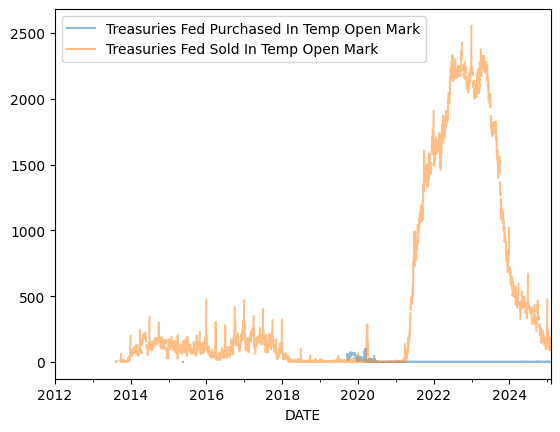

In [17]:
df[['RPONTSYD','RRPONTSYD']].rename(
    columns=pull_public_repo_data.series_descriptions
).plot(alpha=0.5)

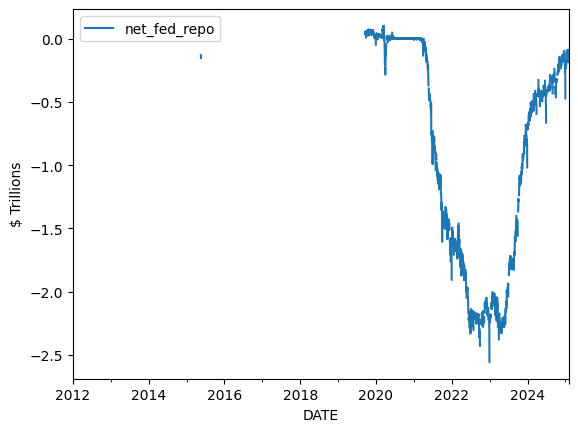

In [18]:
# Net Fed Repo Lending (positive is net lending by the Fed.
# Negative is the use of the reverse repo facility.)
df[['net_fed_repo']].plot()
plt.ylabel('$ Trillions');

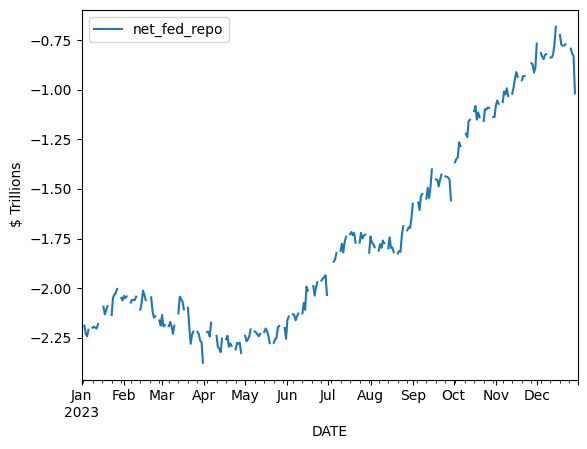

In [19]:
# Net Fed Repo Lending (positive is net lending by the Fed.
# Negative is the use of the reverse repo facility.)
df.loc['2023',['net_fed_repo']].plot()
plt.ylabel('$ Trillions');

(-50.0, 100.0)

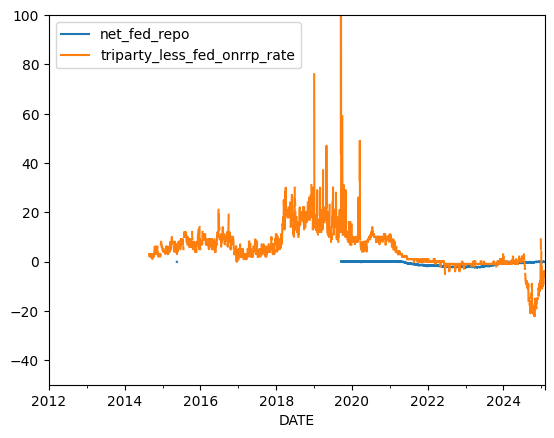

In [20]:
df[['net_fed_repo', 'triparty_less_fed_onrrp_rate']].plot()
plt.ylim([-50,100])

The Fed is lending money when the repo rate is spiking. When the repo rate is low relative to the ON/RRP rate, usage of the ON/RRP facility goes up, as can be seen here.

<Axes: xlabel='DATE'>

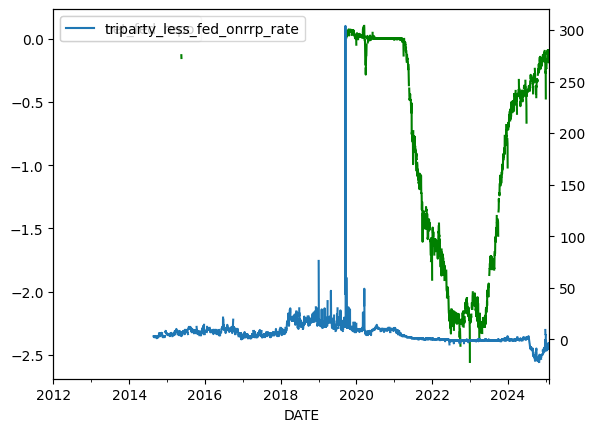

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df[['net_fed_repo']].plot(ax=ax1,color='g')
df[['triparty_less_fed_onrrp_rate']].plot(ax=ax2)

## How should we define a repo spike?

Now, I turn to the question of how to define a repo rate spike. 

### Fed Fund's Target Range

The first way to approach this is to just look at when the triparty rate exceeded the upper bound of the fed's federal funds rate target range.

**Tri-Party Ave vs Fed Upper Limit**

In [22]:
df['is_tri_above_fed_upper'] = df['REPO-TRI_AR_OO-P'] > df['DFEDTARU']

In [23]:
df.index[df['is_tri_above_fed_upper']]

DatetimeIndex(['2018-03-29', '2018-04-02', '2018-04-03', '2018-05-31',
               '2018-06-01', '2018-06-04', '2018-06-29', '2018-11-15',
               '2018-11-30', '2018-12-06', '2018-12-07', '2018-12-17',
               '2018-12-18', '2018-12-19', '2018-12-31', '2019-01-02',
               '2019-01-03', '2019-01-31', '2019-02-28', '2019-03-29',
               '2019-04-30', '2019-05-01', '2019-07-03', '2019-07-05',
               '2019-07-31', '2019-09-16', '2019-09-17', '2019-09-18',
               '2019-09-30', '2019-10-16', '2020-03-04', '2020-03-16',
               '2020-03-17'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [24]:
len(df.index[df['is_tri_above_fed_upper']])

33

**SOFR vs Fed Upper Limit**

In [25]:
df['is_SOFR_above_fed_upper'] = df['SOFR'] > df['DFEDTARU']
len(df.index[df['is_SOFR_above_fed_upper']])

44

In [26]:
df.index[df['is_SOFR_above_fed_upper']]

DatetimeIndex(['2018-04-03', '2018-04-11', '2018-04-16', '2018-04-17',
               '2018-04-30', '2018-05-01', '2018-05-15', '2018-05-31',
               '2018-06-01', '2018-06-04', '2018-06-29', '2018-07-02',
               '2018-11-15', '2018-11-16', '2018-11-30', '2018-12-04',
               '2018-12-06', '2018-12-07', '2018-12-17', '2018-12-18',
               '2018-12-19', '2018-12-31', '2019-01-02', '2019-01-03',
               '2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-01', '2019-07-02', '2019-07-03', '2019-07-05',
               '2019-07-31', '2019-09-16', '2019-09-17', '2019-09-18',
               '2019-09-25', '2019-09-30', '2019-10-16', '2019-10-31',
               '2020-03-16', '2020-03-17', '2024-10-01', '2024-12-26'],
              dtype='datetime64[ns]', name='DATE', freq=None)

**SOFR vs Interest of Reserves**

This measure is good because it represents a kind of arbitrage opportunity. Either leave money at Fed to earn interest, or put money into repo market. This is what the paper, "Reserves were not so amply after all" uses.

<Axes: xlabel='DATE'>

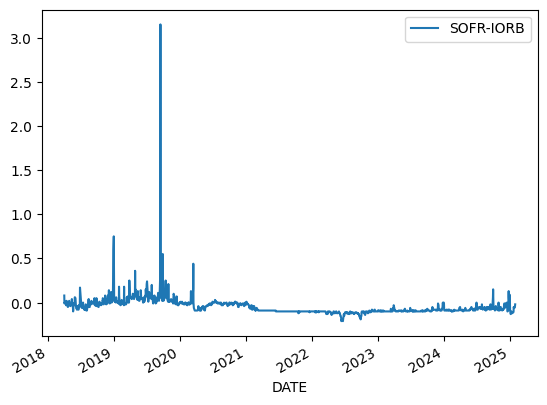

In [27]:
df[['SOFR-IORB']].dropna(how='all').plot()

In [28]:
df['is_SOFR_above_IORB'] =df['SOFR-IORB'] > 0
len(df.index[df['is_SOFR_above_IORB']])

263

In [29]:
df.index[df['is_SOFR_above_IORB']]

DatetimeIndex(['2018-04-03', '2018-04-11', '2018-04-16', '2018-04-17',
               '2018-04-30', '2018-05-01', '2018-05-15', '2018-05-31',
               '2018-06-01', '2018-06-04',
               ...
               '2020-07-21', '2020-11-02', '2020-11-05', '2021-01-05',
               '2024-09-30', '2024-10-01', '2024-10-02', '2024-12-26',
               '2024-12-27', '2024-12-31'],
              dtype='datetime64[ns]', name='DATE', length=263, freq=None)

Now, let's ask if it's 2 standard deviations above IORB

In [30]:
df['SOFR-IORB'].std()

0.10591554345460347

In [31]:
df['is_SOFR_2std_above_IORB'] = df['SOFR-IORB'] > 2 * df['SOFR-IORB'].std()
len(df.index[df['is_SOFR_2std_above_IORB']])

12

In [32]:
df.index[df['is_SOFR_2std_above_IORB']]

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-03-29',
               '2019-04-30', '2019-07-05', '2019-09-16', '2019-09-17',
               '2019-09-18', '2019-09-30', '2019-10-16', '2020-03-17'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [33]:
df['SOFR-IORB'].mean()

-0.04794376098418294

In [34]:
df.index[df['is_SOFR_2std_above_IORB']].intersection(df.index[df['is_SOFR_above_fed_upper']])

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-03-29',
               '2019-04-30', '2019-07-05', '2019-09-16', '2019-09-17',
               '2019-09-18', '2019-09-30', '2019-10-16', '2020-03-17'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [35]:
len(df.index[df['is_SOFR_2std_above_IORB']].intersection(df.index[df['is_SOFR_above_fed_upper']]))

12

In [36]:
filedir = Path(OUTPUT_DIR)
df[
    ['is_SOFR_above_fed_upper', 'is_SOFR_2std_above_IORB', 
    'is_SOFR_above_IORB', 'is_tri_above_fed_upper']
  ].to_csv(filedir / 'is_spike.csv')

## Summary Stats about Various Repo Rates

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4783 entries, 2012-01-01 to 2025-02-03
Data columns (total 50 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   GDP                                        52 non-null     float64
 1   CPIAUCNS                                   156 non-null    float64
 2   GDPC1                                      52 non-null     float64
 3   DPCREDIT                                   4783 non-null   float64
 4   EFFR                                       3286 non-null   float64
 5   OBFR                                       3262 non-null   float64
 6   SOFR                                       1707 non-null   float64
 7   DFEDTARU                                   4783 non-null   float64
 8   DFEDTARL                                   4783 non-null   float64
 9   WALCL                                      4783 non-null   float64
 10  TOTRES

I don't include GCF in this first comparison, because it has a lot of missing values. I want to only compare values for which all rates are non-null. That's why I drop the whole row when any rate is missing.

Here, we see that DVP average is lower than Triparty average. SOFR is closer to triparty, but is still lower. This is because SOFR tries to remove specials.

Notice, however, that this is different when comparing the 75% percentiles. SOFR is higher than triparty and DVP is even higher.

In [38]:
df[['SOFR', 'REPO-TRI_AR_OO-P', 'REPO-DVP_AR_OO-P']].dropna().describe()

,SOFR,REPO-TRI_AR_OO-P,REPO-DVP_AR_OO-P
count,1586.000000,1586.000000,1586.000000
mean,2.371816,2.356047,2.353279
std,2.024820,1.998684,2.029374
min,0.010000,0.020000,-0.080000
25%,0.090000,0.100000,0.090000
50%,2.170000,2.160000,2.150000
75%,4.590000,4.540000,4.600000
max,5.400000,5.330000,5.430000


Now, I include GCF. It appears that GCF is the highest. Borrow low at tri-party, lend higher into SOFR (but lower to specials) and lend highest to GCF.

In [39]:
df[['SOFR', 'REPO-TRI_AR_OO-P', 'REPO-DVP_AR_OO-P', 'REPO-GCF_AR_OO-P']].dropna().describe()

,SOFR,REPO-TRI_AR_OO-P,REPO-DVP_AR_OO-P,REPO-GCF_AR_OO-P
count,106.000000,106.000000,106.000000,106.000000
mean,3.293962,3.276604,3.272830,3.363302
std,1.721574,1.714196,1.723694,1.730514
min,0.010000,0.040000,-0.010000,0.030000
25%,2.075000,2.042500,2.042500,2.170000
50%,2.735000,2.730000,2.665000,2.830000
75%,5.050000,5.040000,5.027500,5.130000
max,5.400000,5.320000,5.390000,5.470000
